In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    RocCurveDisplay
)


In [2]:
df_clean = pd.read_csv("../data/processed/diabetes_clean.csv")
df_clean.shape


(768, 9)

In [3]:
X = df_clean.drop("Outcome", axis=1)
y = df_clean["Outcome"]


In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)


Train: (537, 8)
Val:   (115, 8)
Test:  (116, 8)


In [5]:
with open("../models/scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)
X_train_scaled = scaler.transform(X_train)


In [6]:
with open("../models/baseline_model.pkl", "rb") as f:
    baseline_model = pickle.load(f)

baseline_model


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

In [7]:
y_test_pred_base = baseline_model.predict(X_test_scaled)
y_test_proba_base = baseline_model.predict_proba(X_test_scaled)[:, 1]


In [8]:
def get_metrics(y_true, y_pred, y_proba):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_proba)
    }


In [9]:
baseline_test_metrics = get_metrics(y_test, y_test_pred_base, y_test_proba_base)
baseline_test_metrics


{'accuracy': 0.7931034482758621,
 'precision': 0.717948717948718,
 'recall': 0.6829268292682927,
 'f1': 0.7,
 'roc_auc': 0.8608130081300813}

In [10]:
confusion_matrix(y_test, y_test_pred_base)


array([[64, 11],
       [13, 28]])

In [11]:
print(classification_report(y_test, y_test_pred_base))


              precision    recall  f1-score   support

           0       0.83      0.85      0.84        75
           1       0.72      0.68      0.70        41

    accuracy                           0.79       116
   macro avg       0.77      0.77      0.77       116
weighted avg       0.79      0.79      0.79       116



In [12]:
from tensorflow import keras

dl_model = keras.models.load_model("../models/deep_learning_model.h5")
dl_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 963 (3.77 KB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [13]:
y_test_proba_dl = dl_model.predict(X_test_scaled).ravel()
y_test_pred_dl = (y_test_proba_dl >= 0.5).astype(int)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [14]:
dl_test_metrics = get_metrics(y_test, y_test_pred_dl, y_test_proba_dl)
dl_test_metrics


{'accuracy': 0.7586206896551724,
 'precision': 0.7407407407407407,
 'recall': 0.4878048780487805,
 'f1': 0.5882352941176471,
 'roc_auc': 0.8500813008130081}

In [15]:
confusion_matrix(y_test, y_test_pred_dl)


array([[68,  7],
       [21, 20]])

In [16]:
print(classification_report(y_test, y_test_pred_dl))


              precision    recall  f1-score   support

           0       0.76      0.91      0.83        75
           1       0.74      0.49      0.59        41

    accuracy                           0.76       116
   macro avg       0.75      0.70      0.71       116
weighted avg       0.76      0.76      0.74       116



In [17]:
comparison_df = pd.DataFrame([
    {"model": "Logistic Regression (Balanced)", **baseline_test_metrics},
    {"model": "Deep Learning (Keras)", **dl_test_metrics}
])

comparison_df


,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression (Balanced),0.793103,0.717949,0.682927,0.700000,0.860813
1,Deep Learning (Keras),0.758621,0.740741,0.487805,0.588235,0.850081


<Figure size 640x480 with 0 Axes>

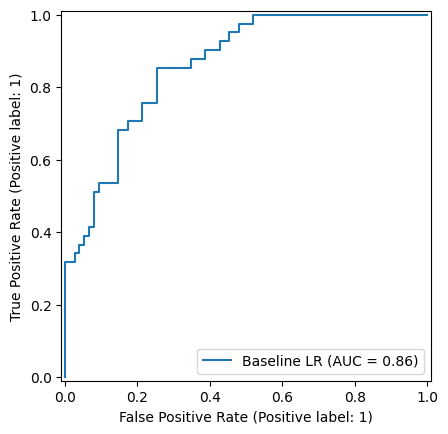

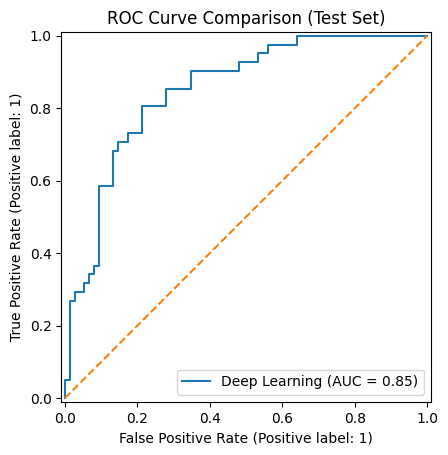

In [18]:
plt.figure()

RocCurveDisplay.from_predictions(y_test, y_test_proba_base, name="Baseline LR")
RocCurveDisplay.from_predictions(y_test, y_test_proba_dl, name="Deep Learning")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve Comparison (Test Set)")
plt.show()


In [19]:
def predict_risk(model, scaler, input_data):
    """
    input_data: dict with keys matching the 8 feature names
    """
    input_df = pd.DataFrame([input_data])
    input_scaled = scaler.transform(input_df)
    
    proba = model.predict_proba(input_scaled)[0, 1]
    prediction = int(proba >= 0.5)
    return prediction, proba


In [20]:
sample_input = {
    "Pregnancies": 2,
    "Glucose": 130,
    "BloodPressure": 70,
    "SkinThickness": 25,
    "Insulin": 120,
    "BMI": 32.0,
    "DiabetesPedigreeFunction": 0.5,
    "Age": 29
}

pred, prob = predict_risk(baseline_model, scaler, sample_input)
pred, prob


(0, np.float64(0.4423175314249779))